# Generative Models
***

**Autumn 2023, MSc course**


## Assignment 2

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***


Let's continue our dive into the classical generative models! Today's goal is to implement Conditional GAN for MNIST dataset. Conditional image generation is the task of generating new images conditional on their class. Feel free to rewrite this skeleton or reuse your code from the previous assignment.

Good luck!

## 1. Conditional GAN
*Source: <a href="https://arxiv.org/pdf/1411.1784.pdf" target="_blank">Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014)</a>.*

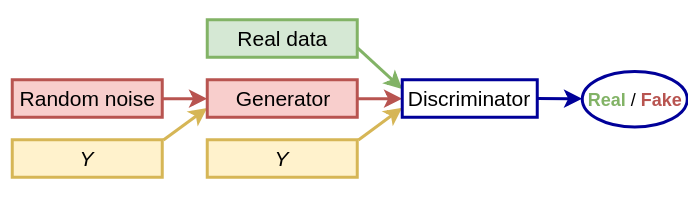

Picture source: https://medium.datadriveninvestor.com/an-introduction-to-conditional-gans-cgans-727d1f5bb011

### Imports

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.display import Image
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image

%matplotlib inline
plt.style.use("ggplot")

### Some parameters

In [2]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"
number_class = 10

if device == "cuda":
    !nvidia-smi

sample_dir = "./images"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Wed Dec 20 22:39:31 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Load dataset and create dataloader

In [3]:
# Load MNIST dataset
mnist = MNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

data_loader = DataLoader(mnist, batch_size=batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 104602194.52it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34620089.69it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30481386.92it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3689103.17it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.73542482, -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.45516339,  0.58745098,  0.71973854,  0.85202616,
         0.98431373]),
 <BarContainer object of 15 artists>)

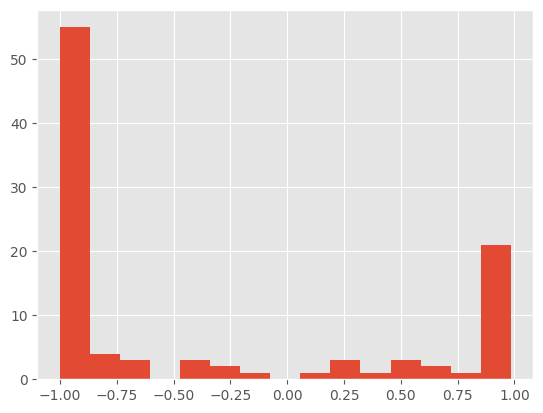

In [5]:
# plot pixels distribution
img, label = mnist[0]
print('Label: ', label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [8]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    return ((x-torch.mean(x))/torch.std(x))

Label: 5


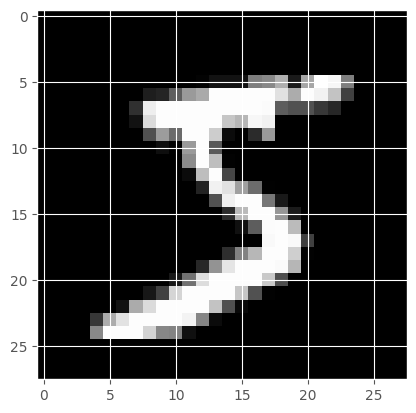

In [10]:
# Let's plot something
img, label = mnist[0]

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap="gray")
print("Label:", label)

### Define the models

Define the Discriminator network, the Generator network with additional input for condition

In [80]:
number_class = 10

class Generator(nn.Module):
    def __init__(self, number_class, latent_size, image_size, hidden_size): # pass number_class and use nn.Embedding here
        # linear1 - relu - linear2 - relu - linear3 - tanh
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.image_size = image_size
        self.embed = nn.Embedding(number_class, number_class)

        self.model = nn.Sequential(
            nn.Linear(latent_size+number_class, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, image_size)
        )

    def forward(self, x, label):
        # concat label embedding with random latent vector
        x = x.view(-1, self.latent_size)
        e = self.embed(label)
        x = torch.cat([x, e], 1)
        out = self.model(x)

        return out.view(-1, self.image_size)


class Discriminator(nn.Module):
    def __init__(self, number_class, image_size, hidden_size): # pass number_class and use nn.Embedding here
        # linear1 - leaky_relu - linear2 - leaky_relu - linear3 - sigmoid
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.embed = nn.Embedding(number_class, number_class)

        self.model = nn.Sequential(
            nn.Linear(image_size+number_class, hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x, label):
        # concat label embedding with input image
        x = x.view(-1, self.image_size)
        e = self.embed(label)
        x = torch.cat([x, e], 1)
        out = self.model(x)
        return out

Answer the question: why the last layer of generator is $Tanh$ and the last discriminator layer is $Sigmoid$?

In [81]:
# create new Generator model

G = Generator(number_class,latent_size, image_size, hidden_size).to(device)

# create new Discriminator model

D = Discriminator(number_class, image_size, hidden_size).to(device)

In [82]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
optim_G = torch.optim.Adam(G.parameters(), lr=LR)
optim_D = torch.optim.Adam(D.parameters(), lr=LR)

### Discriminator Training

In [83]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    optim_D.zero_grad()
    optim_G.zero_grad()


def train_discriminator(images, labels, n_class):

    # Loss for real images
    real_labels = torch.ones(batch_size, 1).to(device)
    outputs = D(images, labels)
    d_loss_real = criterion(outputs, real_labels)

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    fake_images = G(z, labels)
    fake_outputs = D(fake_images, labels)
    d_loss_fake = criterion(fake_outputs, fake_labels)

    # Combine losses
    d_loss = d_loss_real + d_loss_fake

    # Reset gradients
    reset_grad()

    d_loss.backward()

    # Adjust the parameters using backprop
    optim_D.step()

    return d_loss, d_loss_real, d_loss_fake

### Generator Training

In [90]:
def train_generator():
    # Sample random vector
    z = torch.randn(batch_size, latent_size).to(device)
    gens_label = torch.randint(0, 9, (batch_size,)).to(device)

    # Generate fake images and calculate loss
    fake_images = G(z, gens_label)
    labels = torch.ones(batch_size, 1).to(device)
    outputs = D(fake_images, gens_label)
    g_loss = criterion(outputs, labels)
    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    optim_G.step()

    return g_loss, fake_images

### Start the training proccess

In [89]:
def save_fake_images(index):
    # Sample random vector
    sample_vectors = torch.randn(batch_size, latent_size).to(device)
    gens_label = torch.randint(0, 9, (batch_size,)).to(device)
    # Generate images with Generator
    fake_images = G(sample_vectors, gens_label)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [92]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, digit) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.view(batch_size, -1).to(device)
        digit = digit.to(device)
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images, digit, number_class)
        g_loss, fake_images = train_generator()
        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images(epoch + 1)

Epoch [0/300], Step [200/600], d_loss: 0.1885, g_loss: 4.8256, D(x): 0.08, D(G(z)): 0.11
Epoch [0/300], Step [400/600], d_loss: 0.1991, g_loss: 4.1472, D(x): 0.06, D(G(z)): 0.14
Epoch [0/300], Step [600/600], d_loss: 0.0666, g_loss: 5.1742, D(x): 0.05, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.1894, g_loss: 3.7292, D(x): 0.10, D(G(z)): 0.09
Epoch [1/300], Step [400/600], d_loss: 0.4573, g_loss: 3.3657, D(x): 0.11, D(G(z)): 0.34
Epoch [1/300], Step [600/600], d_loss: 0.3508, g_loss: 4.1634, D(x): 0.19, D(G(z)): 0.16
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.7545, g_loss: 3.6095, D(x): 0.52, D(G(z)): 0.23
Epoch [2/300], Step [400/600], d_loss: 0.9723, g_loss: 3.7367, D(x): 0.18, D(G(z)): 0.79
Epoch [2/300], Step [600/600], d_loss: 0.2979, g_loss: 3.6043, D(x): 0.26, D(G(z)): 0.04
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.3747, g_loss: 3.4200, D(x): 0.28, D(G(z)): 0.09
Epoch [3/300], Step [400/6

KeyboardInterrupt: ignored

### Show your conditional generation results for each class independently

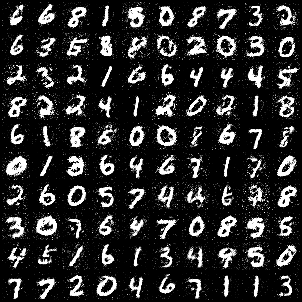

In [102]:
from PIL import Image
Image.open(os.path.join(sample_dir, "fake_images-0210.png"))

In [149]:
labels = torch.Tensor([0,1,2,3,4,5,6,7,8,9]).type(torch.int32).to(device)
sample_vectors = torch.randn(10, latent_size).to(device)
out = G(sample_vectors, labels)


In [145]:
def denorm(x):
    return ((x-torch.mean(x))/torch.std(x))

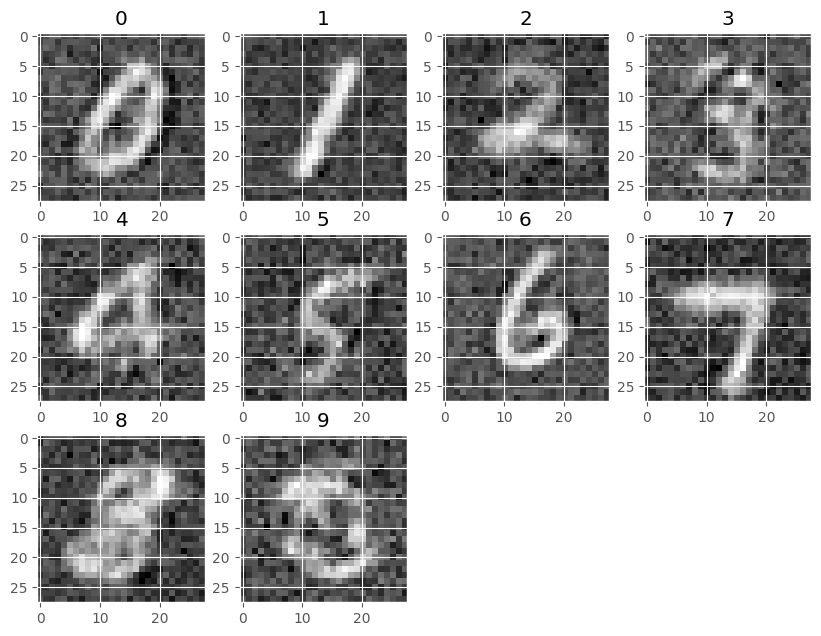

In [150]:
fig = plt.figure(figsize=(10, 10))

for i in range(10):
    fig.add_subplot(4, 4, i+1)
    img= out[i].view(1,28,28).detach().cpu()
    img = np.transpose(denorm(img),(1,2,0))
    label = labels[i].item()
    plt.title(label)
    plt.imshow(img, cmap='Greys_r')

In [ ]:
!zip -r file.zip ./images

In [104]:
from google.colab import files
files.download('./file.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

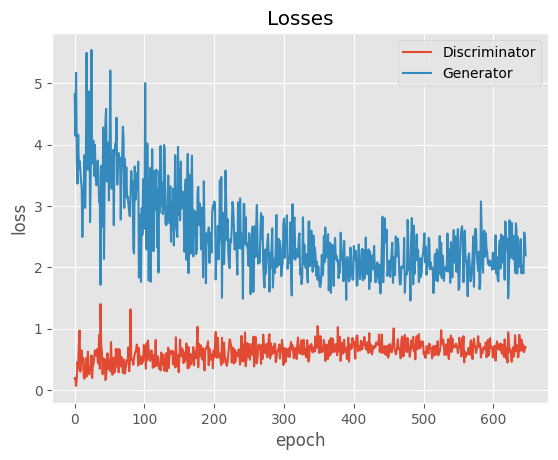

In [93]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

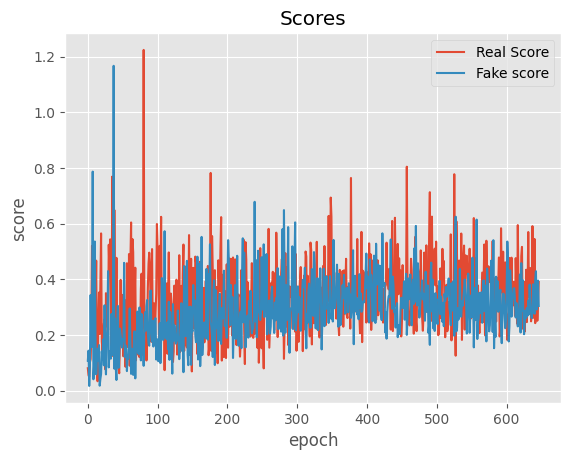

In [94]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");